In [13]:
import numpy as np
import pandas as pd
import volpriceinference as vl
import matplotlib as mpl
import seaborn as sns
import logging
import tqdm
from multiprocessing import Pool
import sys
from functools import partial
import cdpm

In [14]:
%matplotlib inline
mpl.style.use('seaborn-talk')
np.set_printoptions(precision=3)

In [15]:
logging.captureWarnings(True)
root_logger = logging.getLogger()
root_logger.setLevel(logging.INFO)
info_handler = logging.FileHandler('../logging.tmp.txt')
info_handler.addFilter(lambda record: record.levelno <= logging.WARNING)
error_handler = logging.StreamHandler(sys.stderr)
error_handler.addFilter(lambda record: record.levelno > logging.WARNING)
root_logger.addHandler(info_handler)
root_logger.addHandler(error_handler)

## Setup the True Parameters /  Simulation Parameters

In [16]:
kharpov = True

In [22]:
if kharpov:
    true_params = {'theta': 1.7680, 
               'pi': -10,
               'phi': -.4,
               'log_scale': np.log(252 * 1.564e-5),
#                 'log_scale' : np.log(.1),
                'log_both': np.log(0.6475) + np.log(252 * 1.564e-5),
               'rho': .5,
              }
else:
#     Daily
     true_params ={'log_both': 0.8819415995231439,
                   'log_scale': 1.7813838683227812,
                   'rho': 0.5294015291756116,
                   'phi': -0.29799406819991614,
#                    'pi': 0.05812774870906164,
                    'pi': 0, 
                   'theta': 0.43003184804533173}
#     Weekly
#     true_params = {'log_both': -0.2768983372209973 + 0.805773558068805,
#                    'log_scale': 0.805773558068805,
#                    'rho': 0.6097218157104826,
#                    'phi': -0.8999999994952989,
#                    # Here I use the daily value.
#                    'pi': -.01,
#                    'theta': 2.6348432313374923}
    
time_dim = 2000
sim_dim = 1000
innov_dim = 250

In [23]:
vl.__version__

'0.0.15-py36_0'

In [25]:
total_true_params = true_params.copy()
total_true_params.update(
    {'gamma': vl.compute_gamma(**true_params),
     'beta':vl.compute_beta(rho=true_params['rho'], log_scale=true_params['log_scale'],
                            phi=true_params['phi'], pi=true_params['pi'], theta=true_params['theta']),
     'psi':vl.compute_psi(rho=true_params['rho'], log_scale=true_params['log_scale'], phi=true_params['phi'], 
                  theta=true_params['theta']),
      'zeta': 1 - true_params['phi']**2})

In [28]:
def compute_moments(log_both, rho, log_scale, phi, pi, theta):
    
    vol_mean = np.exp(log_both) / (1 - rho)
    vol_var = (2 * np.exp(log_scale) * rho * vol_mean + np.exp(log_scale)**2 * np.exp(log_both - log_scale)) / (1 - rho**2)
    
    psi = vl.compute_psi(rho=rho, log_scale=log_scale, phi=phi, theta=theta)
    beta = vl.compute_beta(rho=rho, log_scale=log_scale, phi=phi, pi=pi, theta=theta)
    gamma = vl.compute_gamma(log_both=log_both, rho=rho, log_scale=log_scale, phi=phi, pi=pi, theta=theta)
    
    return_mean = psi * vol_mean + beta * vol_mean + gamma
    return_var = psi**2 * vol_var + beta**2 * vol_var  + (1 - phi**2) * vol_mean
    
    return {'return_mean': return_mean, 'return_var': return_var, 'vol_mean': vol_mean, 'vol_var': vol_var}

In [29]:
compute_moments(**true_params)

{'return_mean': 0.007673354139615026,
 'return_var': 0.005024656065865211,
 'vol_mean': 0.005103957600000001,
 'vol_var': 4.023225201945602e-05}

In [30]:
vl.compute_gamma(**true_params)

0.012227592917921712

In [31]:
total_true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.4,
 'log_scale': -5.536249735335685,
 'log_both': -5.97088622074413,
 'rho': 0.5,
 'gamma': 0.012227592917921712,
 'beta': 2.5479117458224314,
 'psi': -3.440207320203121,
 'zeta': 0.84}

In [32]:
true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.4,
 'log_scale': -5.536249735335685,
 'log_both': -5.97088622074413,
 'rho': 0.5}

In [33]:
total_true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.4,
 'log_scale': -5.536249735335685,
 'log_both': -5.97088622074413,
 'rho': 0.5,
 'gamma': 0.012227592917921712,
 'beta': 2.5479117458224314,
 'psi': -3.440207320203121,
 'zeta': 0.84}

## We start by examining the distributions of simulated data

In [34]:
data = vl.simulate_data(time_dim=time_dim, **true_params)

In [35]:
data.corr()

,vol,rtn
vol,1.000000,-0.243647
rtn,-0.243647,1.000000


In [36]:
omega, omega_cov = vl.estimate_params(data)

In [37]:
omega

{'gamma': 0.01232648059419449,
 'beta': 2.5423636824880265,
 'psi': -3.6293012285605646,
 'zeta': 0.8235279355335888,
 'log_both': -5.946531576244861,
 'log_scale': -5.54912865900595,
 'rho': 0.438535070871968}

In [38]:
omega_cov

,beta,gamma,log_both,log_scale,psi,rho,zeta
beta,0.008263,-2.023863e-05,0.000000,0.000000,-0.003939,0.000000,0.000000
gamma,-0.000020,1.543604e-07,0.000000,0.000000,-0.000013,0.000000,0.000000
log_both,0.000000,0.000000e+00,0.002877,0.000967,0.000000,-0.001258,0.000000
log_scale,0.000000,0.000000e+00,0.000967,0.002437,0.000000,-0.000064,0.000000
psi,-0.003939,-1.272380e-05,0.000000,0.000000,0.094737,0.000000,0.000000
rho,0.000000,0.000000e+00,-0.001258,-0.000064,0.000000,0.001141,0.000000
zeta,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000691


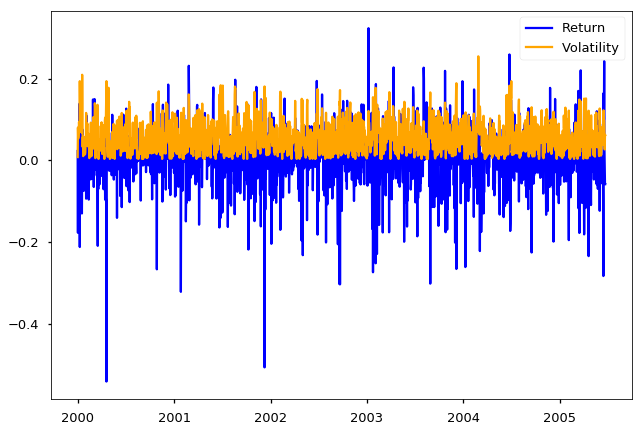

In [39]:
fig1, ax1 = mpl.pyplot.subplots()
ax1.plot(data.rtn, label='Return', color='blue')
ax1.plot(data.vol.apply(np.sqrt), label='Volatility', color='orange')

ax1.legend()

In [40]:
data.transform(lambda x: np.sqrt(x) if x.name == 'vol' else x).cov()

,vol,rtn
vol,0.001419,-0.000555
rtn,-0.000555,0.004367


In [41]:
total_true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.4,
 'log_scale': -5.536249735335685,
 'log_both': -5.97088622074413,
 'rho': 0.5,
 'gamma': 0.012227592917921712,
 'beta': 2.5479117458224314,
 'psi': -3.440207320203121,
 'zeta': 0.84}

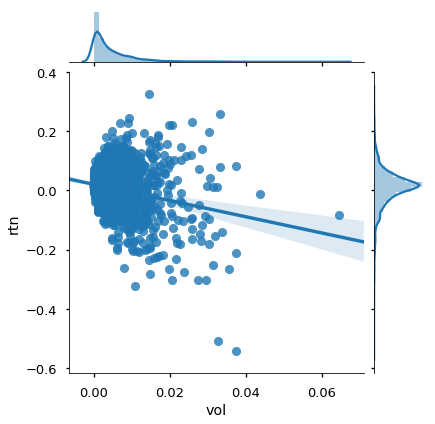

In [42]:
sns.jointplot(x='vol', y='rtn', data=data, kind='reg')

In [43]:
data.describe()

,vol,rtn
count,2000.000000,2000.000000
mean,0.004682,0.007238
std,0.005890,0.066085
min,0.000010,-0.542000
25%,0.000752,-0.017910
50%,0.002568,0.013891
75%,0.006424,0.038648
max,0.064669,0.323195


# I now import  robust conditional QLR statistic 

In [110]:
if kharpov:
    filename = '../results/reject_prop_kharpov_{}_{}_{}.json'.format(250, -0.3, 10000)
else:
    filename = '../results/reject_prop_{}_{}_{}.json'.format(innov_dim, true_params['phi'], 
                                                                         time_dim)

In [111]:
filename

'../results/reject_prop_kharpov_250_-0.3_10000.json'

In [112]:
returnval = pd.read_json(filename)

In [113]:
pd.DataFrame(stats.chi2.cdf(returnval.qlr_stat, df=4) > .95).mean()

0    0.017
dtype: float64

In [114]:
returnval.query('robust_qlr_qauntile > 0').mean()

qlr_stat               2.803011
robust_qlr_qauntile    6.965274
robust                 0.053000
standard               0.037000
dtype: float64

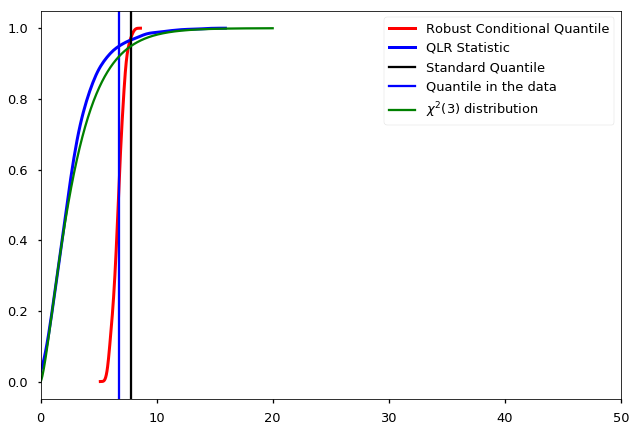

In [90]:
fig4, ax4 = mpl.pyplot.subplots()
try:
    sns.distplot(returnval.query('robust_qlr_qauntile > 0').robust_qlr_qauntile, 
                 kde_kws={"color": "red", "lw": 3, 'cumulative':True}, ax=ax4,hist=False, 
                 label='Robust Conditional Quantile')
           
except AttributeError:
    pass

sns.distplot(returnval.qlr_stat, hist=False, ax=ax4,kde_kws={"color": "blue", "lw": 3, 'cumulative':True},
      label='QLR Statistic')
ax4.axvline(stats.chi2.ppf(.95, df=3), color='black', label='Standard Quantile')
ax4.axvline(np.percentile(returnval.qlr_stat, 95),  color='Blue', label='Quantile in the data')

xvals = np.linspace(0, 20, 500)
ax4.plot(xvals, [stats.chi2.cdf(x, df=3) for x in xvals], color='green', label='$\chi^2(3)$ distribution')
ax4.set_xlim([0,50])
# ax4.set_ylim([0,.5])
ax4.set_xlabel("")
ax4.legend()
fig4.savefig('../doc/figures/reject_prop_{}_{}.tmp.pdf'.format(innov_dim, true_params['phi']),
            frameon=False, pad_inches=0, bbox_inces='tight', transparent=True)